In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import soundfile as sf
import librosa
from librosa.display import specshow
import pandas as pd


from argparse import ArgumentParser
from tqdm import tqdm
import random, sys, math, gzip, os, json, copy, datetime
from IPython.display import Audio 
import IPython
import soundfile 

sys.path.append('../')
from dataloader.nsynthdataset import NSynthDataSet
from util import util
from transformer.transformers import GTransformer

%load_ext autoreload
%autoreload 2

np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
config = util.get_config('../config/config-emb256.json')
data_dir = config['data_dir']
sample_rate = config['sample_rate']
batch_size = config['batch_size']
lr = config['lr']
lr_warmup = config['lr_warmup']
epochs = config['epochs']

sample_length = config['sample_length']
embedding_size = config['embedding_size'] 
num_heads = config['num_heads']
depth = config['depth']
num_tokens = config['num_tokens']

lower_pitch_limit = config['lower_pitch_limit']
upper_pitch_limit = config['upper_pitch_limit']

In [3]:
model_interp = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model_interp = model_interp.cuda()

opt_interp = torch.optim.Adam(lr=lr, params=model_interp.parameters())
sch_interp = torch.optim.lr_scheduler.LambdaLR(opt_interp, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss_interp = torch.nn.NLLLoss(reduction='mean')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_interp)

3257088

In [5]:
print(model_interp)

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=256, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=128, out_features=256, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=256, out_features=256, bias=False)
        (toqueries): Linear(in_features=256, out_features=256, bias=False)
        (tovalues): Linear(in_features=256, out_features=256, bias=False)
        (unifyheads): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Se

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawEncodeInput(inputd):
    inputd = (librosa.mu_compress(inputd, quantize=False) + 1)/2
    return inputd

def mulawDecodeInput(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

def mulawEncodeTarget(inputd):
    target = librosa.mu_compress(inputd, quantize=True) + 127
    target = target.astype(np.long)
    return target

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

In [7]:
def get_data_from_location(idx, start_location, incr=1): #start_location is sample position and not timestamp

    if idx == 'random':
        input_data = np.random.rand((sample_length)) * 0.1
        audio_data = input_data
        target = np.random.rand((sample_length))
    else:
        audio_file_name = os.path.join(data_dir, idx+'.wav')
        audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
        input_data = audio_data[start_location:start_location + sample_length]
    
    target = audio_data[start_location + incr:start_location + incr + sample_length] #Ignore target. Not used in this notebook
    target = librosa.mu_compress(target, quantize=True) + 127
    target = target.astype(np.long)
    
    return input_data, target

In [8]:
model_interp, opt_interp, loss_interp, epoch_interp = load_model(model_interp, opt_interp, '../checkpoint-emb256/models/40000.pt')
print('Model Loaded -> ', epoch_interp, loss_interp)

Model Loaded ->  40000 NLLLoss()


In [10]:
activation_tblocks = {}
activation_embedding = {}
activation_toprobs = {}
def register_activation_by_name(activationtype, ind):
    def hook(model, inputd, output):
        o = output#.detach() # Do not detach. We need backprop for computing Saliency
        
        if activationtype == 'tblock_key':
            activation_tblocks[f'tblock_key_{ind}'] = o
        elif activationtype == 'tblock_query':
            activation_tblocks[f'tblock_query_{ind}'] = o
        elif activationtype == 'token_embedding_activation':
            activation_embedding['token_embedding'] = o
        else:
            activation_toprobs['toprobs'] = o
    return hook

for ind, tblock in enumerate(model_interp.tblocks):
    tblock.attention.tokeys.register_forward_hook(register_activation_by_name('tblock_key', ind))
    tblock.attention.toqueries.register_forward_hook(register_activation_by_name('tblock_query', ind))
    
model_interp.token_embedding.register_forward_hook(register_activation_by_name('token_embedding_activation', ind))
model_interp.toprobs.register_forward_hook(register_activation_by_name('toprobs', ind))

In [11]:
def get_attention_matrix(key_name, query_name): #Code extracted from transformer/modules.py 
    tblock_key = activation_tblocks[key_name].detach()
    tblock_query = activation_tblocks[query_name].detach()
    
    tblock_key   = tblock_key.view(b, t, h, s)/ (e ** (1/4))
    tblock_query = tblock_query.view(b, t, h, s)/ (e ** (1/4))
    tblock_key = tblock_key.transpose(1, 2).contiguous().view(b * h, t, s)
    tblock_query = tblock_query.transpose(1, 2).contiguous().view(b * h, t, s)
    
    attention = torch.bmm(tblock_query, tblock_key.transpose(1,2))
    util.mask_(attention, maskval=float('-inf'), mask_diagonal=False) #autoregressive mask
    attention = F.softmax(attention, dim=2)
    
    return attention

# Attention Visualisation

## Visualising attention heads - 1(a)
Seed: Brass; Pitch=68; 

Predict one sample and visualise the attention matrix. 

**Note in the visualisation that**:
* Layer 0 & 1 attends to mostly last sample in the seed
* Layer 2 & 3 attends to the predicted sample's corresponding position in the previous wavelength (irrespective of peaks or troughs). 


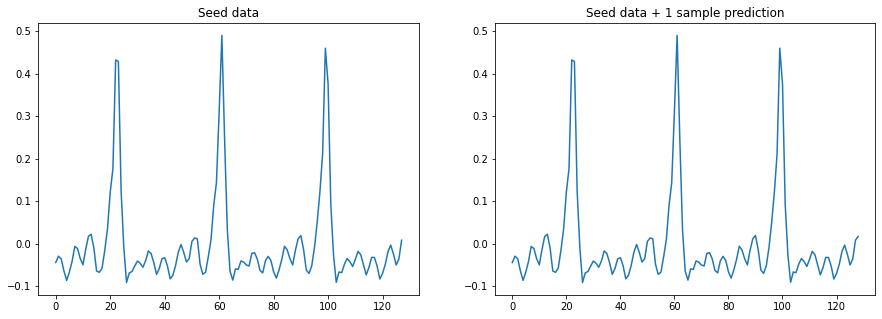

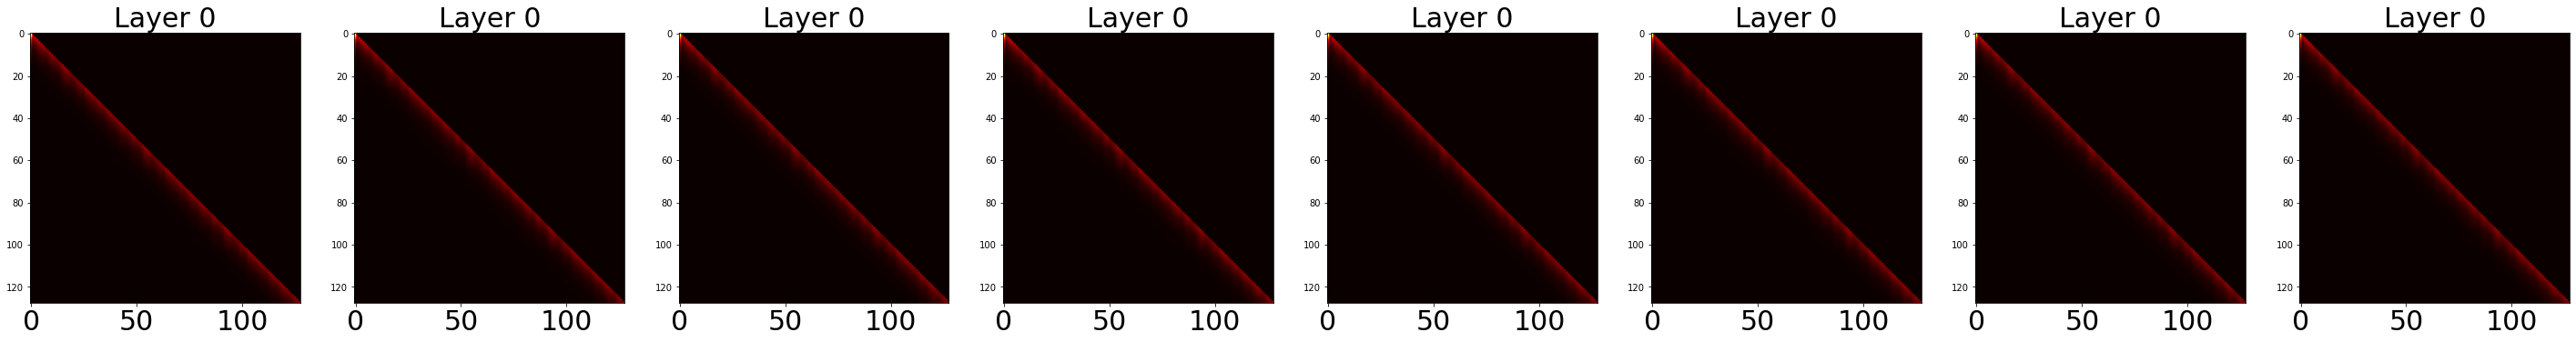

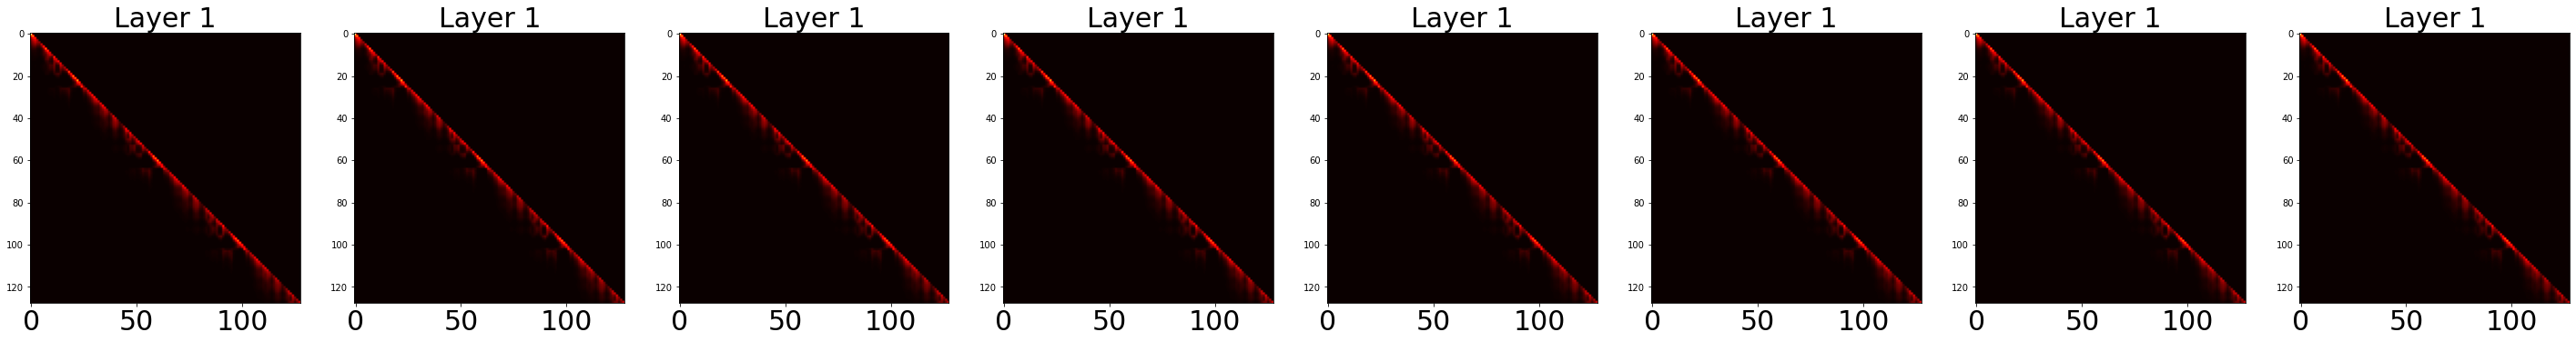

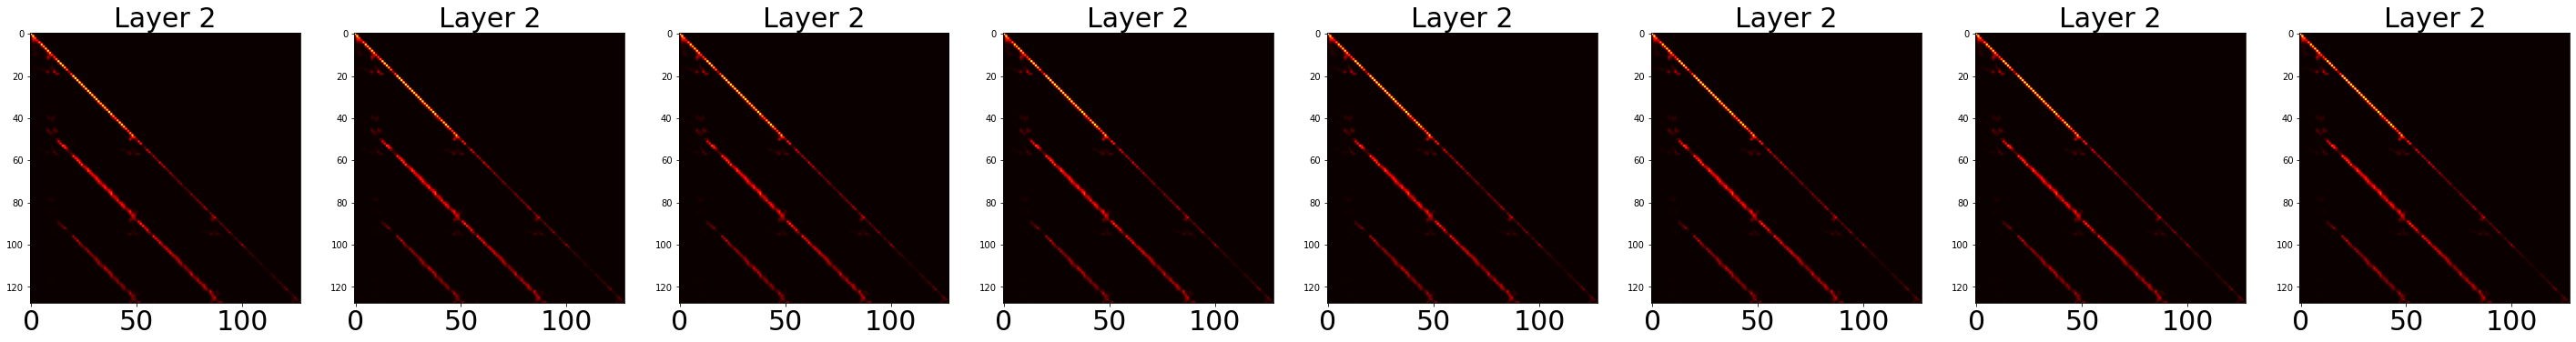

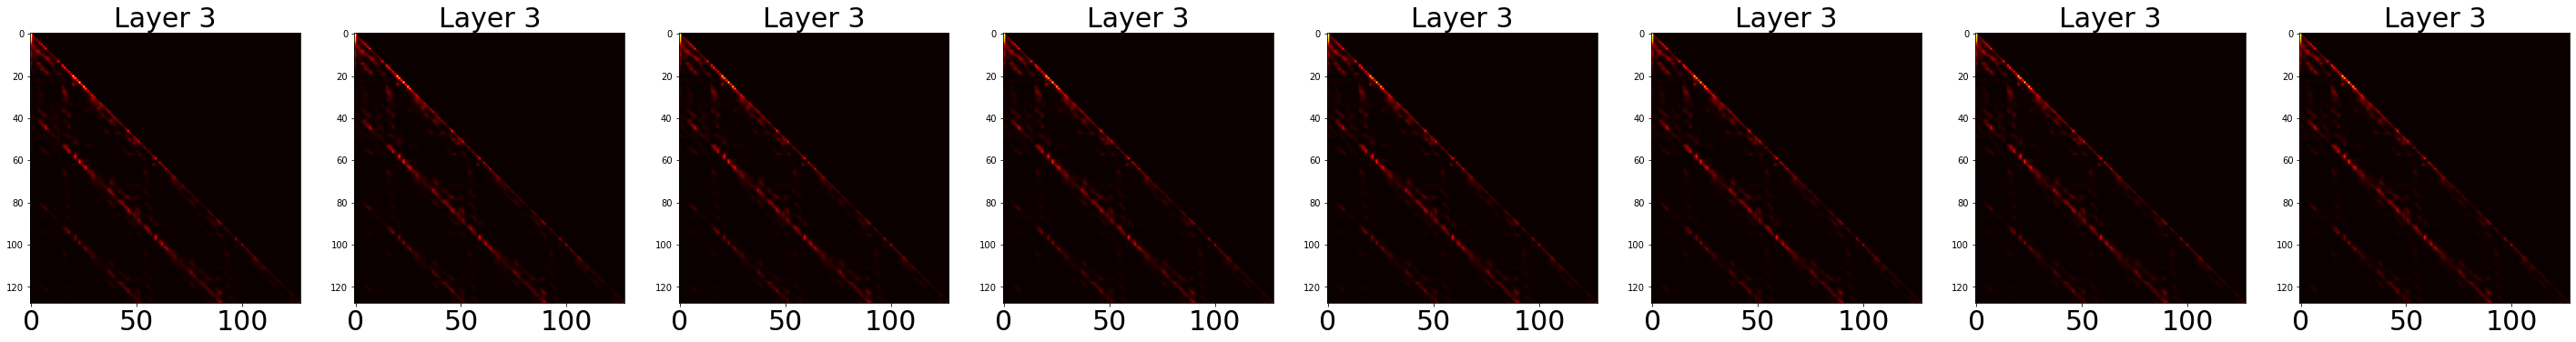

In [71]:
model_interp.eval()
X_data, y_data = get_data_from_location('brass_acoustic_018-068-a.90', 1000)
X_data = X_data.astype(np.float)
y_data = y_data.astype(np.long)
X = mulawEncodeInput(X_data)
input_pitch = np.broadcast_to(np.array([get_scaled_pitch(68)]), X.shape)
scale = np.broadcast_to(np.array([0.9]), X.shape)
instrument = np.broadcast_to(np.array([0]), X.shape)

X = np.stack((input_pitch, scale, instrument, X), axis=1)

X = torch.from_numpy(X).float().cuda()
y = torch.from_numpy(y_data).cuda()

X = X.view(1, -1, 4).float()

y_pred = model_interp(X)

y_pred_sample = y_pred[0, -1, :].argmax()
y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
X_pred = np.append(X_data, y_pred_sample)

#--- Plotting

e = 256 #embedding size
h = 8 #num heads
b = 1 #batch
t = 128 #sample len

s = e//h 

attention_0 = get_attention_matrix('tblock_key_0', 'tblock_query_0')
attention_1 = get_attention_matrix('tblock_key_1', 'tblock_query_1')
attention_2 = get_attention_matrix('tblock_key_2', 'tblock_query_2')
attention_3 = get_attention_matrix('tblock_key_3', 'tblock_query_3')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + 1 sample prediction')
axes[1].plot(X_pred)
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 0', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_0.shape[0]):
        axis.imshow(attention_0[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 1', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_1.shape[0]):
        axis.imshow(attention_1[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 2', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_2.shape[0]):
        axis.imshow(attention_2[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 3', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_3.shape[0]):
        axis.imshow(attention_3[ind].cpu(), cmap=plt.cm.hot)



## Visualising attention heads - 1(b)
Seed: Brass; Pitch=76; 

Predict one sample and visualise the attention matrix. 

**Note that**:
* Same as example 1(a) - Layer's 0 & 1 tend to the last sample in the input and 2 & 3 attend to their corresponding positions in the previous wavelength.
* Note that the heads attend more frequently in this example than 1(a) - probably because this example (pitch 76) has shorter wavelengths than previous example (pitch 64)

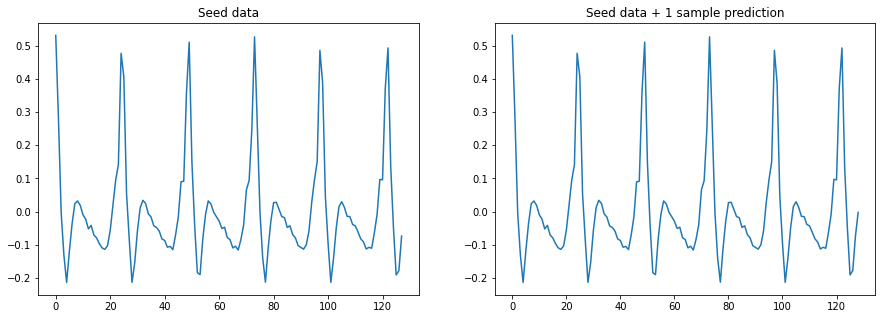

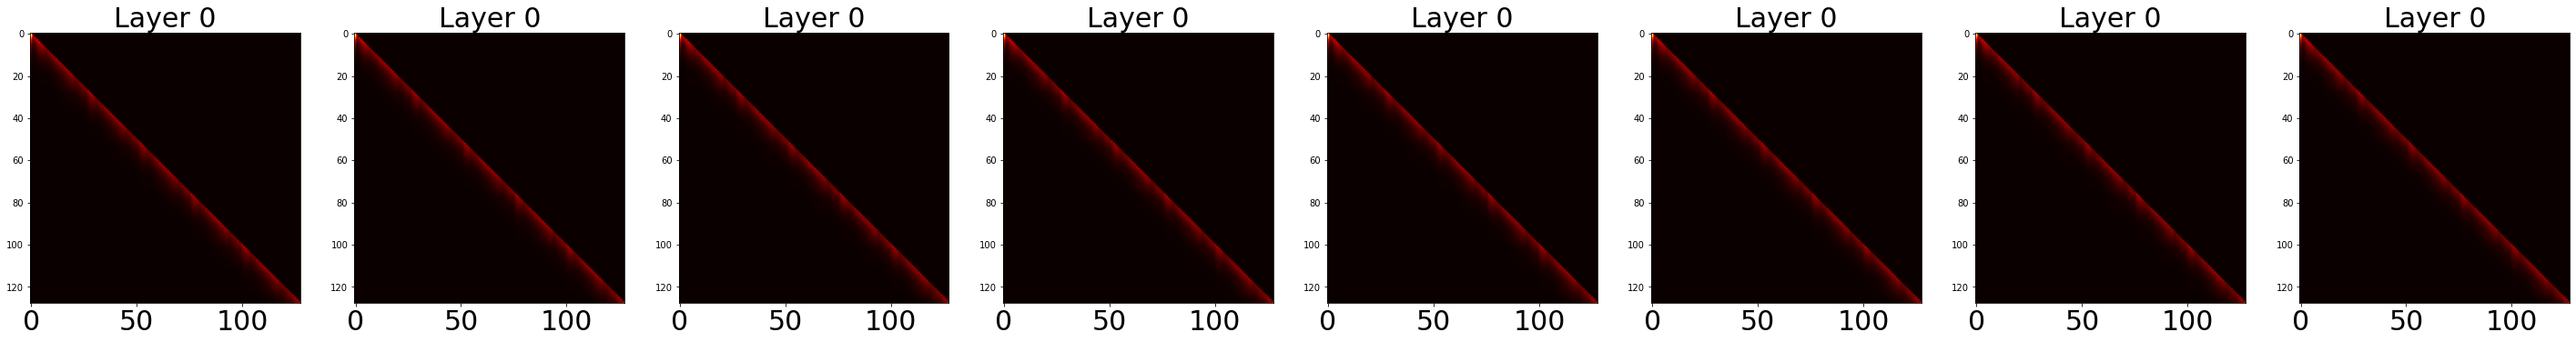

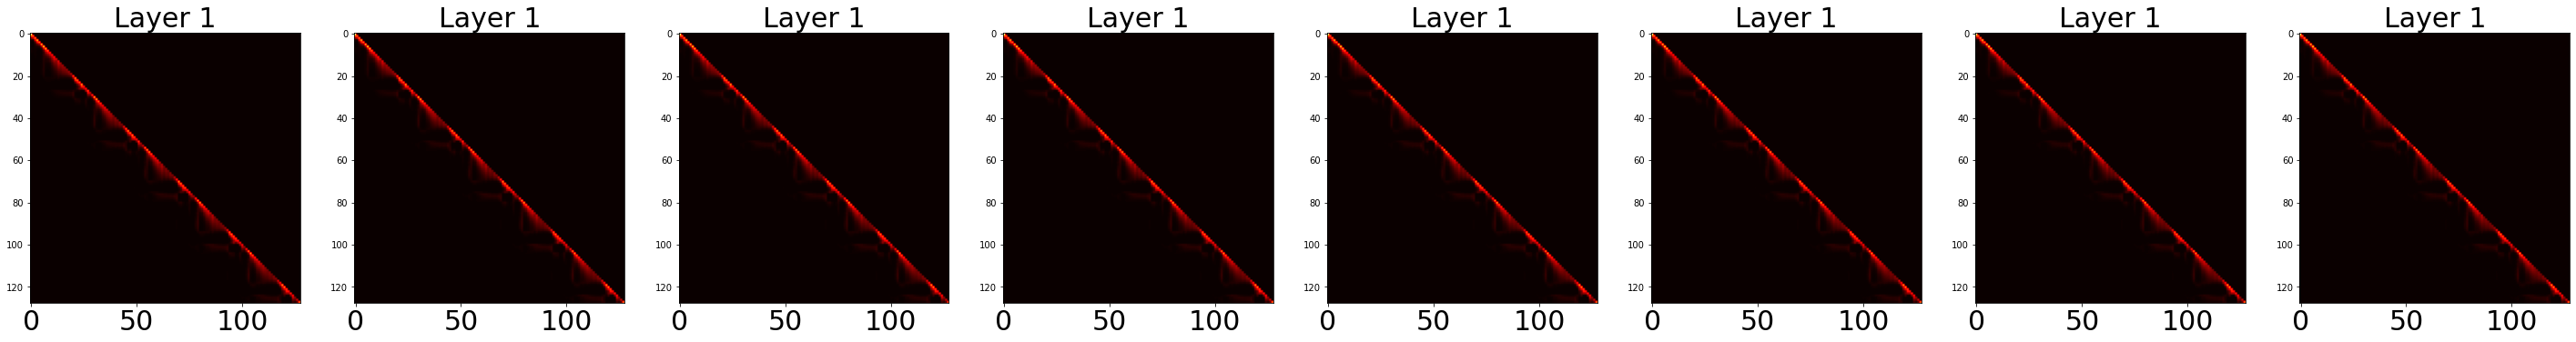

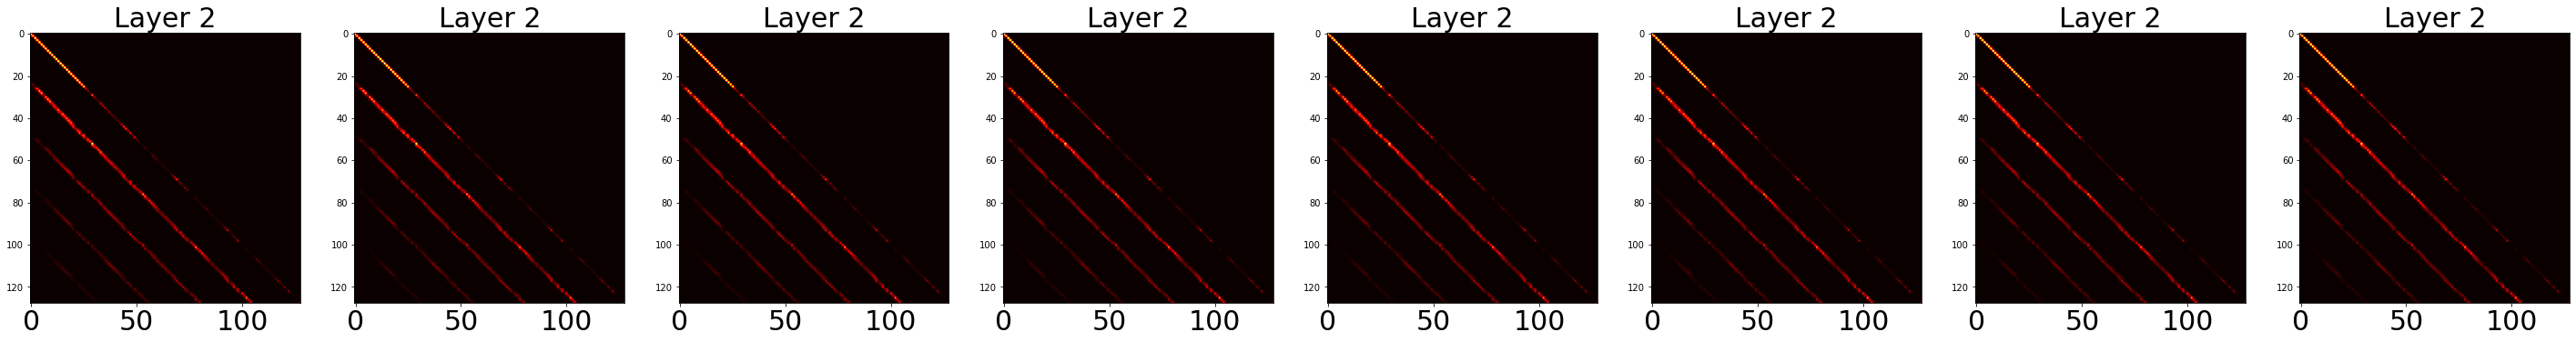

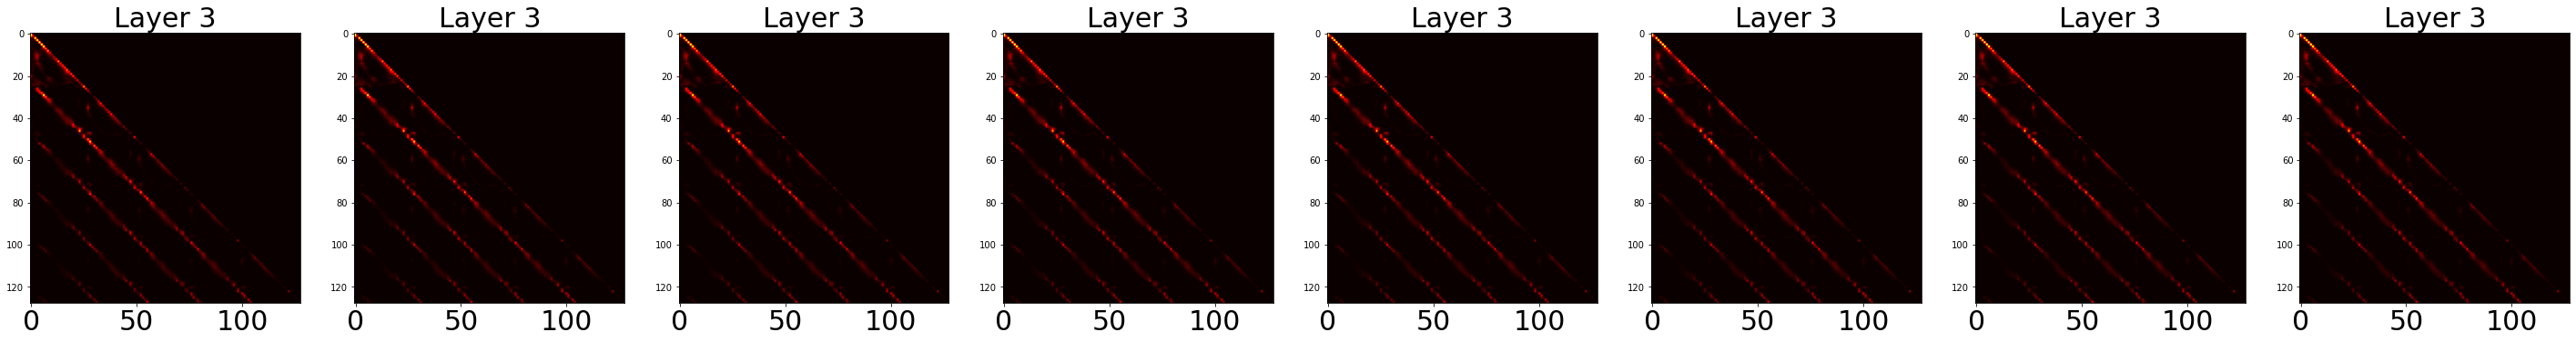

In [70]:
model_interp.eval()
X_data, y_data = get_data_from_location('brass_acoustic_018-076-a.90', 993)
X_data = X_data.astype(np.float)
y_data = y_data.astype(np.long)
X = mulawEncodeInput(X_data)
input_pitch = np.broadcast_to(np.array([get_scaled_pitch(76)]), X.shape)
scale = np.broadcast_to(np.array([0.9]), X.shape)
instrument = np.broadcast_to(np.array([0]), X.shape)

X = np.stack((input_pitch, scale, instrument, X), axis=1)

X = torch.from_numpy(X).float().cuda()
y = torch.from_numpy(y_data).cuda()

X = X.view(1, -1, 4).float()

y_pred = model_interp(X)

y_pred_sample = y_pred[0, -1, :].argmax()
y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
X_pred = np.append(X_data, y_pred_sample)

#--- Plotting

e = 256 #embedding size
h = 8 #num heads
b = 1 #batch
t = 128 #sample len

s = e//h 

attention_0 = get_attention_matrix('tblock_key_0', 'tblock_query_0')
attention_1 = get_attention_matrix('tblock_key_1', 'tblock_query_1')
attention_2 = get_attention_matrix('tblock_key_2', 'tblock_query_2')
attention_3 = get_attention_matrix('tblock_key_3', 'tblock_query_3')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + 1 sample prediction')
axes[1].plot(X_pred)

fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 0', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_0.shape[0]):
        axis.imshow(attention_0[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 1', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_1.shape[0]):
        axis.imshow(attention_1[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 2', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_2.shape[0]):
        axis.imshow(attention_2[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 3', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_3.shape[0]):
        axis.imshow(attention_3[ind].cpu(), cmap=plt.cm.hot)

## Visualising attention heads - 1(c)
Seed & Pitch=Random noise; 

Predict one sample and visualise the attention matrix. 

**Note that**:
* Since the seed/input does not have a waveform to attend to, the heads simply attend to the last sample in the input at all layers. 

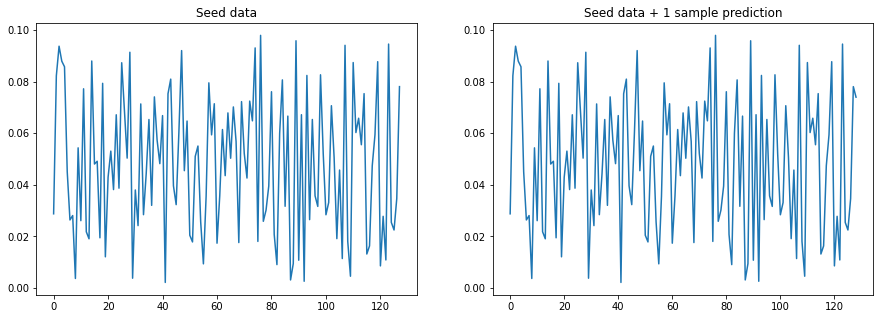

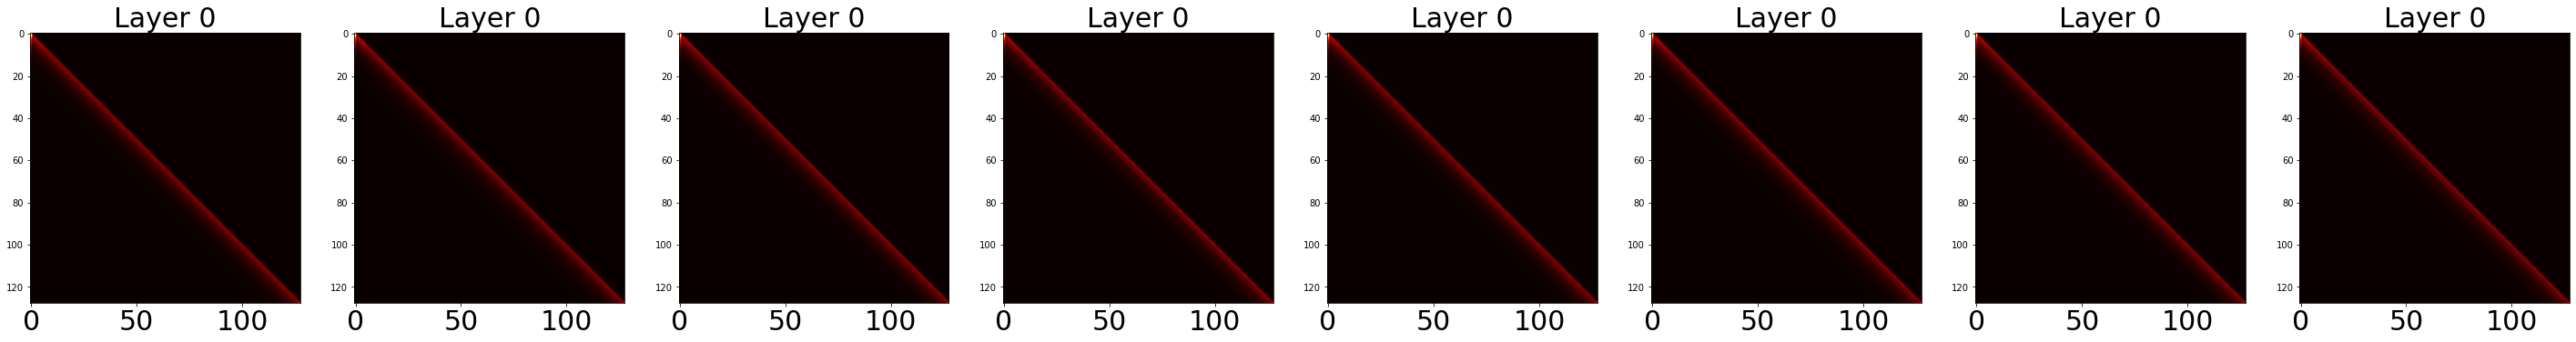

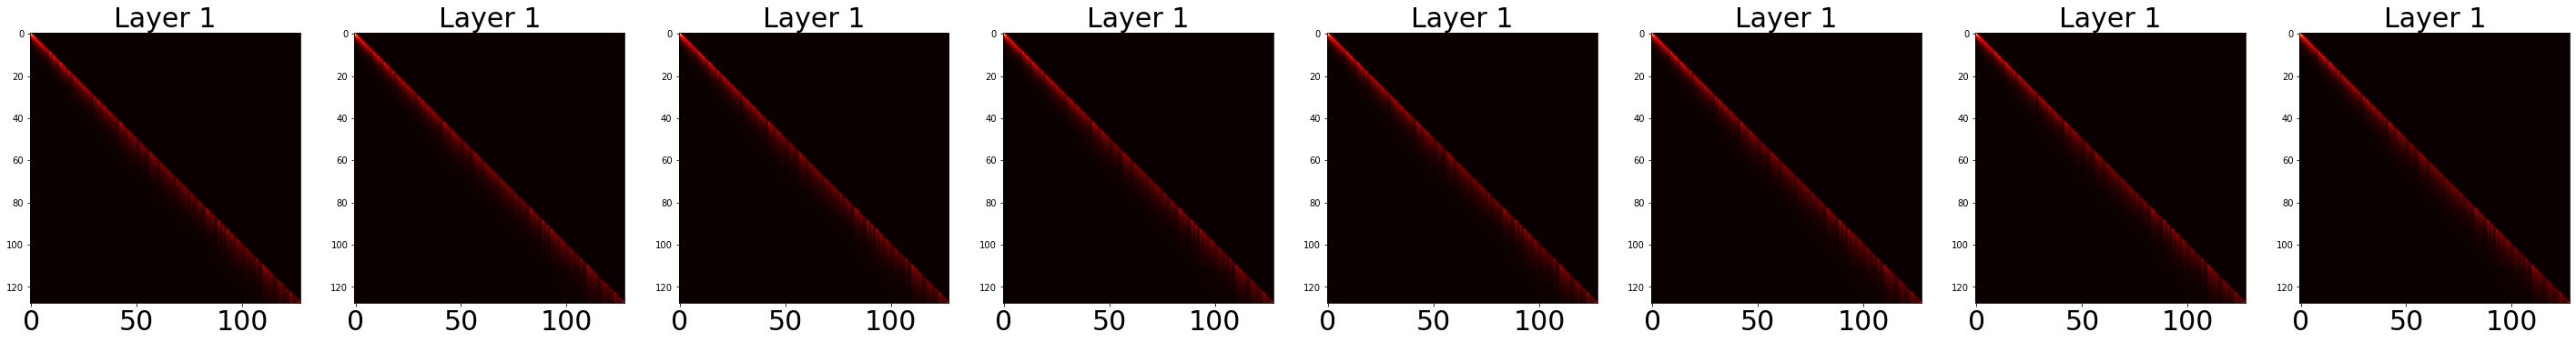

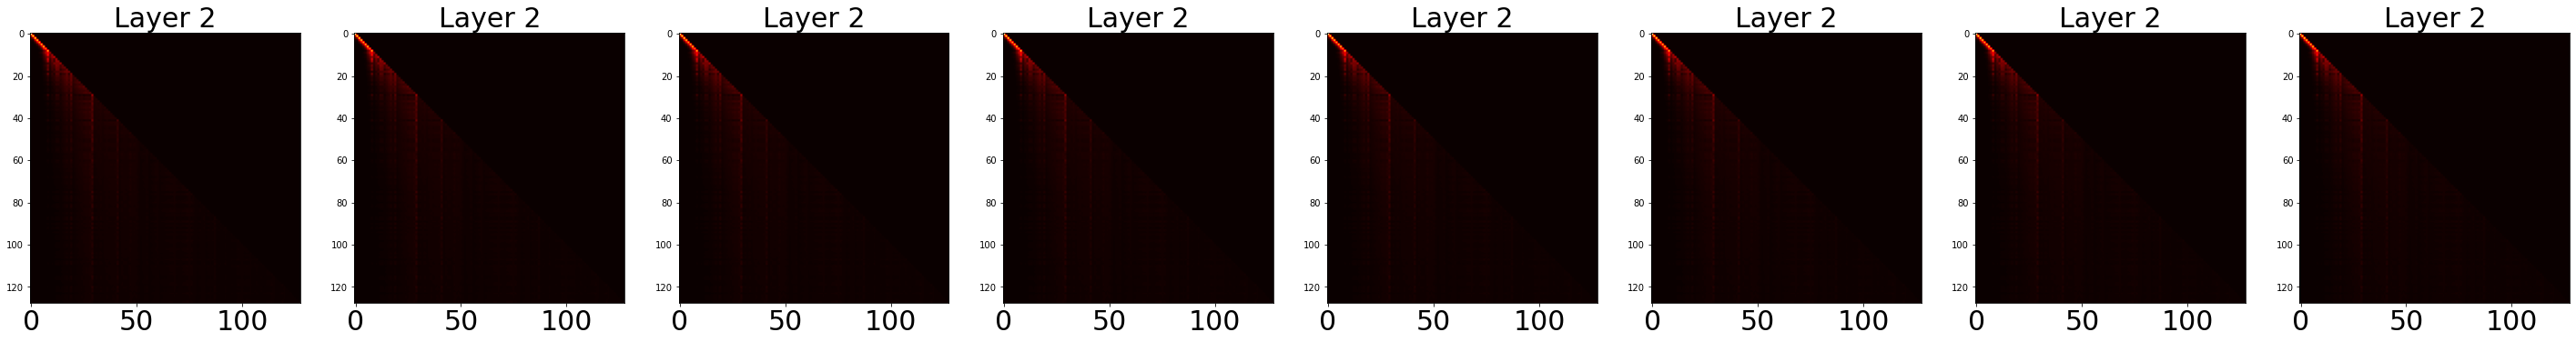

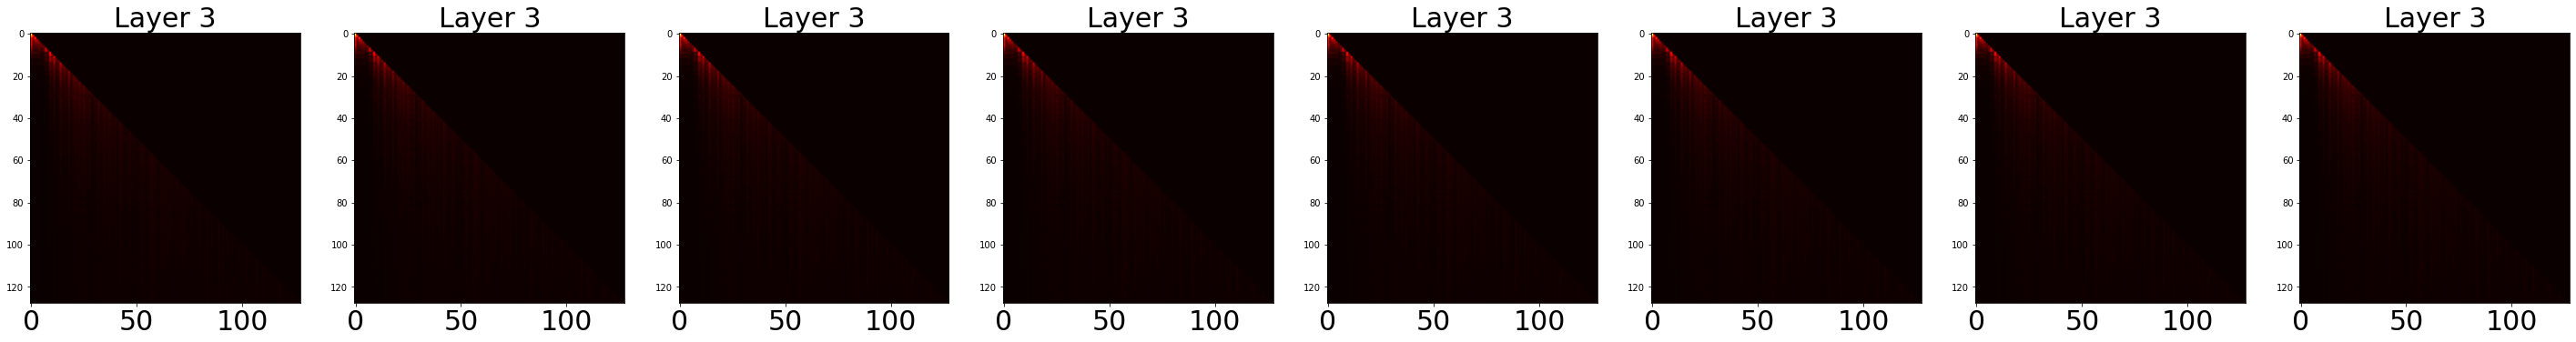

In [72]:
model_interp.eval()
X_data, y_data = get_data_from_location('random', 0)
X_data = X_data.astype(np.float)
y_data = y_data.astype(np.long)
X = mulawEncodeInput(X_data)
input_pitch = np.broadcast_to(np.array([get_scaled_pitch(76)]), X.shape)
scale = np.broadcast_to(np.array([0.9]), X.shape)
instrument = np.broadcast_to(np.array([0]), X.shape)

X = np.stack((input_pitch, scale, instrument, X), axis=1)

X = torch.from_numpy(X).float().cuda()
y = torch.from_numpy(y_data).cuda()

X = X.view(1, -1, 4).float()

y_pred = model_interp(X)

y_pred_sample = y_pred[0, -1, :].argmax()
y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
X_pred = np.append(X_data, y_pred_sample)

#--- Plotting

e = 256 #embedding size
h = 8 #num heads
b = 1 #batch
t = 128 #sample len

s = e//h 

attention_0 = get_attention_matrix('tblock_key_0', 'tblock_query_0')
attention_1 = get_attention_matrix('tblock_key_1', 'tblock_query_1')
attention_2 = get_attention_matrix('tblock_key_2', 'tblock_query_2')
attention_3 = get_attention_matrix('tblock_key_3', 'tblock_query_3')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + 1 sample prediction')
axes[1].plot(X_pred)

fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 0', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_0.shape[0]):
        axis.imshow(attention_0[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 1', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_1.shape[0]):
        axis.imshow(attention_1[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 2', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_2.shape[0]):
        axis.imshow(attention_2[ind].cpu(), cmap=plt.cm.hot)
        
fig, axes = plt.subplots(nrows=1, ncols=h, figsize=(50, 50))
for i, axis in enumerate(axes):
    axis.set_title('Layer 3', fontdict={'fontsize': 30})
    axis.tick_params(axis='x', labelsize=30)
    for ind in range(attention_3.shape[0]):
        axis.imshow(attention_3[ind].cpu(), cmap=plt.cm.hot)

# Saliency for Transformer explainability

This section was developed based on the transformer explainability paper 'The elephant in the interpretability room: Why use attention as explanation when we have saliency methods?' by Bastings et al - https://arxiv.org/pdf/2010.05607.pdf and this really great blogpost by Alammar, Jay - https://jalammar.github.io/explaining-transformers/  

Saliency measure indicates a change in which input sample has the most affect on the currently generated next output sample.

**Note on the visualisation**:
The seed is input such that the next prediction is a peak. Please see the saliency map for the audio data where the gradients seem to be tracking the peak. This is inline with our attention matrix visualisation above. 

Also, the pitch, scale and instrument saliency indicate that the values for pitch, scale and instrument at the peaks or troughs 

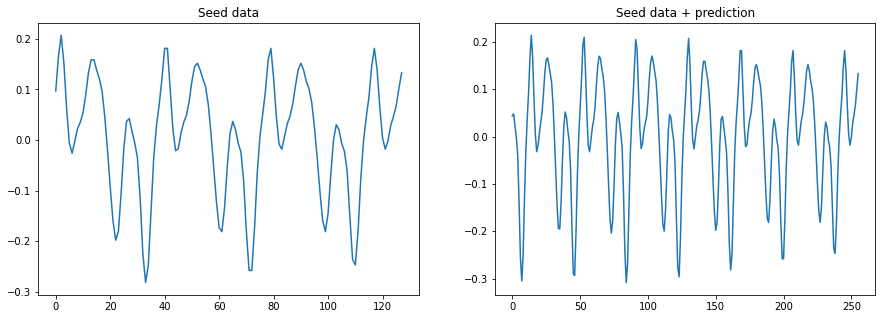

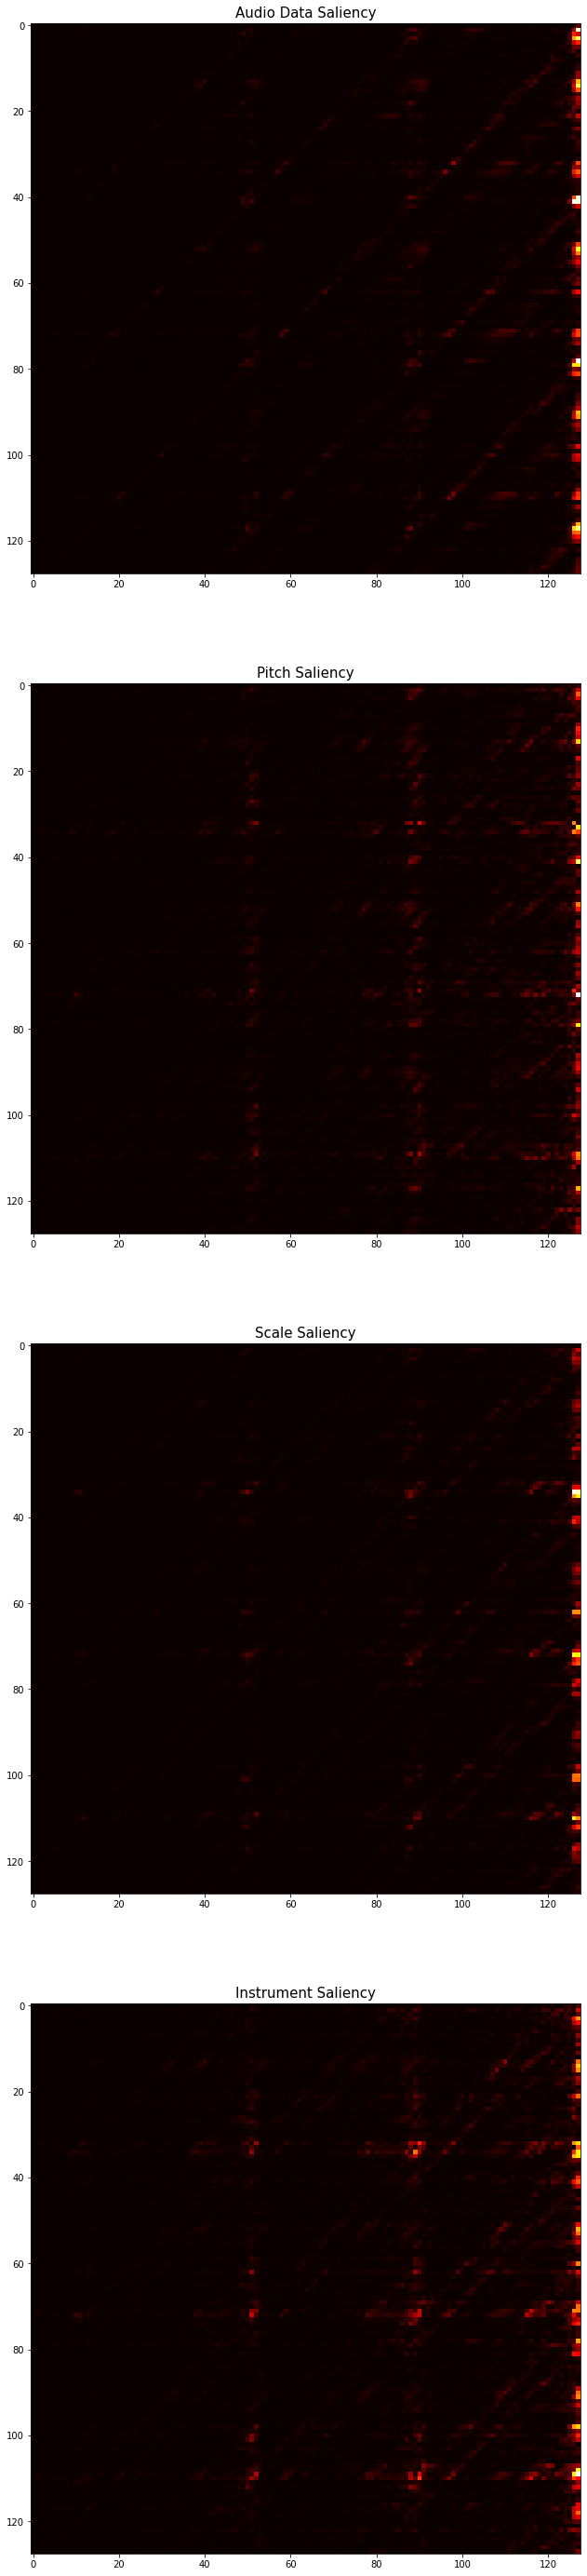

In [121]:
p_saliency = np.empty((0,128))
s_saliency = np.empty((0,128))
i_saliency = np.empty((0,128))
d_saliency = np.empty((0,128))

total_count = 128

X_data, y_data = get_data_from_location('reed_acoustic_000-068-a.90', 1018)
X_data_final = copy.copy(X_data)
for count in range(0,total_count,1):
    
    X_data = X_data.astype(np.float)
    X = mulawEncodeInput(X_data)
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(68)]), X.shape)
    scale = np.broadcast_to(np.array([0.9]), X.shape)
    instrument = np.broadcast_to(np.array([1]), X.shape)

    X = np.stack((input_pitch, scale, instrument, X), axis=1)

    X = torch.from_numpy(X).float()


    X_var = Variable(X, requires_grad=True).cuda()
    X_var.retain_grad()
    X_var_u = X_var.view(1, 128, 4)
    saliency = None


    y_pred = model_interp(X_var_u)
    y_pred_sample = y_pred[0, -1, :].argmax()
    y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
    X_data_final = np.append(X_data_final, y_pred_sample)
    
    X_data = X_data_final[X_data_final.shape[0]-sample_length:]
    
    
    y_pred = activation_toprobs['toprobs'][-1,:]
    y_pred = y_pred[y_var[-1]]
    y_pred.backward()

    saliency = X_var.grad.data

    saliency = saliency.abs() 
    pitch_saliency = torch.norm((saliency[:,0] * X_var[:,0]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    scale_saliency = torch.norm((saliency[:,1] * X_var[:,1]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    instrument_saliency = torch.norm((saliency[:,2] * X_var[:,2]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    data_saliency = torch.norm((saliency[:,3] * X_var[:,3]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    
    p_saliency = np.append(p_saliency, pitch_saliency, axis=0)
    s_saliency = np.append(s_saliency, scale_saliency, axis=0)
    i_saliency = np.append(i_saliency, instrument_saliency, axis=0)
    d_saliency = np.append(d_saliency, data_saliency, axis=0)
    

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + prediction')
axes[1].plot(X_data_final)
fig, axes = plt.subplots(nrows=4, figsize=(50, 50))

axes[0].imshow(d_saliency, cmap=plt.cm.hot)
axes[0].set_title('Audio Data Saliency', fontdict={'fontsize': 15})
axes[0].tick_params(axis='x')


axes[1].imshow(p_saliency, cmap=plt.cm.hot)
axes[1].set_title('Pitch Saliency', fontdict={'fontsize': 15})
axes[1].tick_params(axis='x')

axes[2].imshow(s_saliency, cmap=plt.cm.hot)
axes[2].set_title('Scale Saliency', fontdict={'fontsize': 15})
axes[2].tick_params(axis='x')

axes[3].imshow(i_saliency, cmap=plt.cm.hot)
axes[3].set_title('Instrument Saliency', fontdict={'fontsize': 15})
axes[3].tick_params(axis='x')

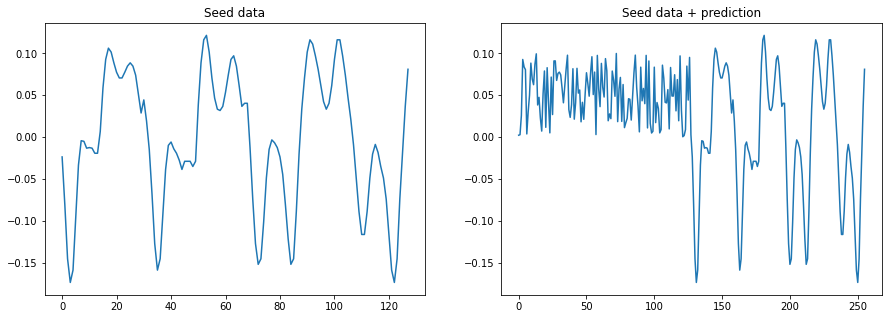

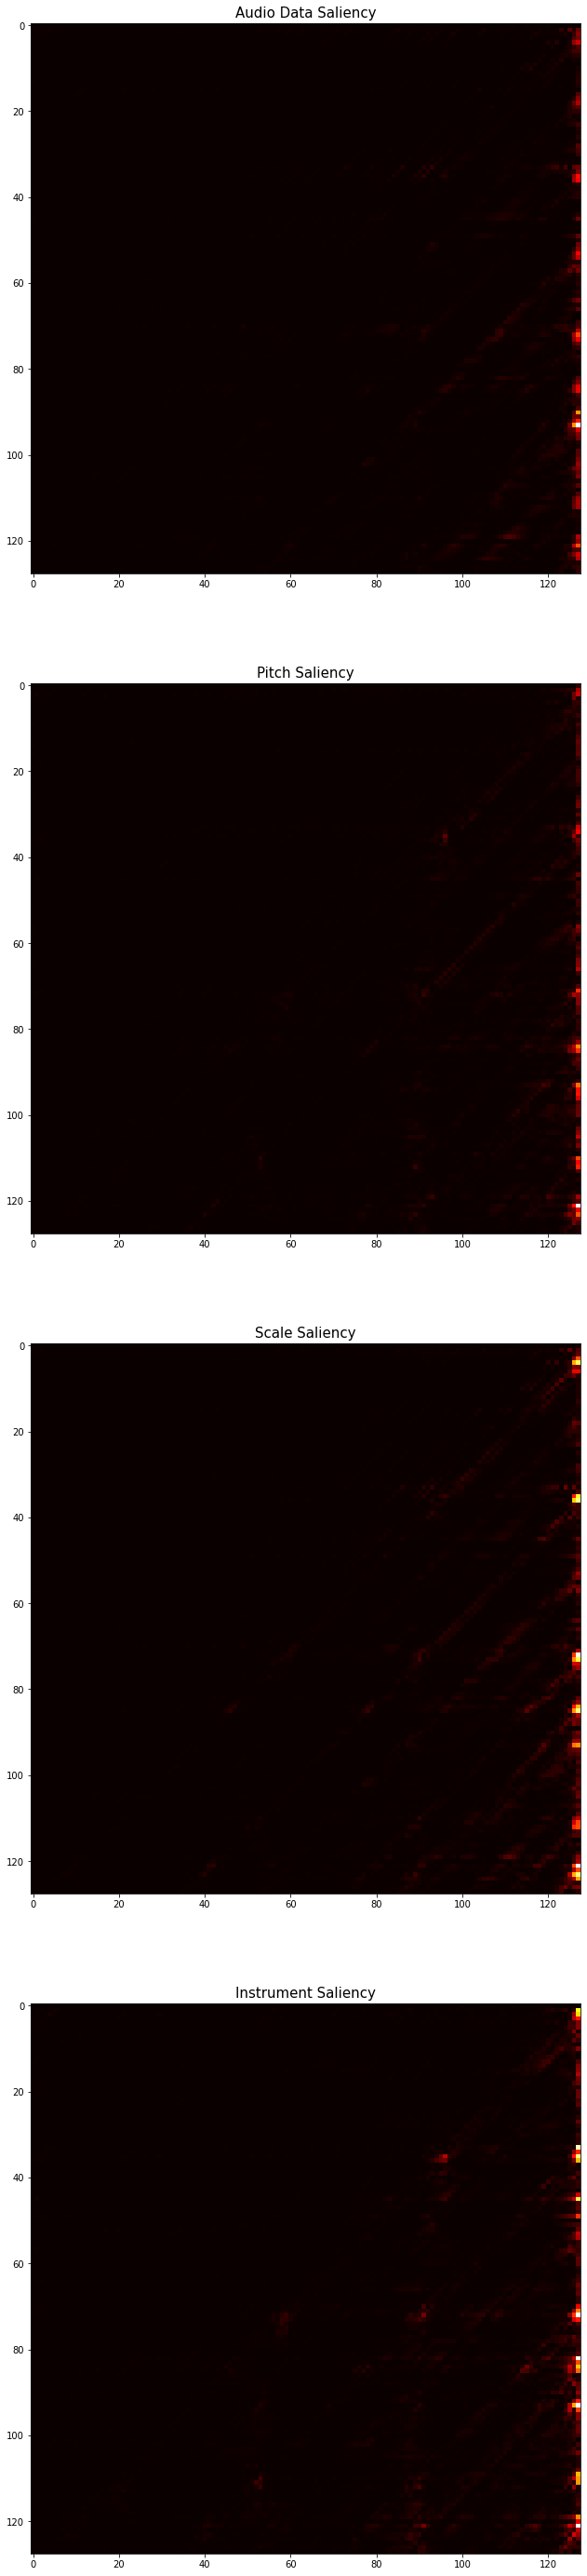

In [120]:
p_saliency = np.empty((0,128))
s_saliency = np.empty((0,128))
i_saliency = np.empty((0,128))
d_saliency = np.empty((0,128))

total_count = 128

X_data, y_data = get_data_from_location('random', 0)
X_data_final = copy.copy(X_data)
for count in range(0,total_count,1):
    
    X_data = X_data.astype(np.float)
    X = mulawEncodeInput(X_data)
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(68)]), X.shape)
    scale = np.broadcast_to(np.array([0.9]), X.shape)
    instrument = np.broadcast_to(np.array([1]), X.shape)

    X = np.stack((input_pitch, scale, instrument, X), axis=1)

    X = torch.from_numpy(X).float()


    X_var = Variable(X, requires_grad=True).cuda()
    X_var.retain_grad()
    X_var_u = X_var.view(1, 128, 4)
    saliency = None


    y_pred = model_interp(X_var_u)
    y_pred_sample = y_pred[0, -1, :].argmax()
    y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
    X_data_final = np.append(X_data_final, y_pred_sample)
    
    X_data = X_data_final[X_data_final.shape[0]-sample_length:]
    
    
    y_pred = activation_toprobs['toprobs'][-1,:]
    y_pred = y_pred[y_var[-1]]
    y_pred.backward()

    saliency = X_var.grad.data

    saliency = saliency.abs() 
    pitch_saliency = torch.norm((saliency[:,0] * X_var[:,0]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    scale_saliency = torch.norm((saliency[:,1] * X_var[:,1]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    instrument_saliency = torch.norm((saliency[:,2] * X_var[:,2]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    data_saliency = torch.norm((saliency[:,3] * X_var[:,3]).reshape(1,-1), dim=0).detach().cpu().numpy().reshape(1,128)
    
    p_saliency = np.append(p_saliency, pitch_saliency, axis=0)
    s_saliency = np.append(s_saliency, scale_saliency, axis=0)
    i_saliency = np.append(i_saliency, instrument_saliency, axis=0)
    d_saliency = np.append(d_saliency, data_saliency, axis=0)
    

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + prediction')
axes[1].plot(X_data_final)
fig, axes = plt.subplots(nrows=4, figsize=(50, 50))

axes[0].imshow(d_saliency, cmap=plt.cm.hot)
axes[0].set_title('Audio Data Saliency', fontdict={'fontsize': 15})
axes[0].tick_params(axis='x')


axes[1].imshow(p_saliency, cmap=plt.cm.hot)
axes[1].set_title('Pitch Saliency', fontdict={'fontsize': 15})
axes[1].tick_params(axis='x')

axes[2].imshow(s_saliency, cmap=plt.cm.hot)
axes[2].set_title('Scale Saliency', fontdict={'fontsize': 15})
axes[2].tick_params(axis='x')

axes[3].imshow(i_saliency, cmap=plt.cm.hot)
axes[3].set_title('Instrument Saliency', fontdict={'fontsize': 15})
axes[3].tick_params(axis='x')

## BACKUP - 

### Overall saliency - without splitting into data, pitch, instrument and scale saliencies.

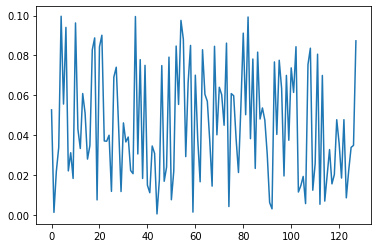

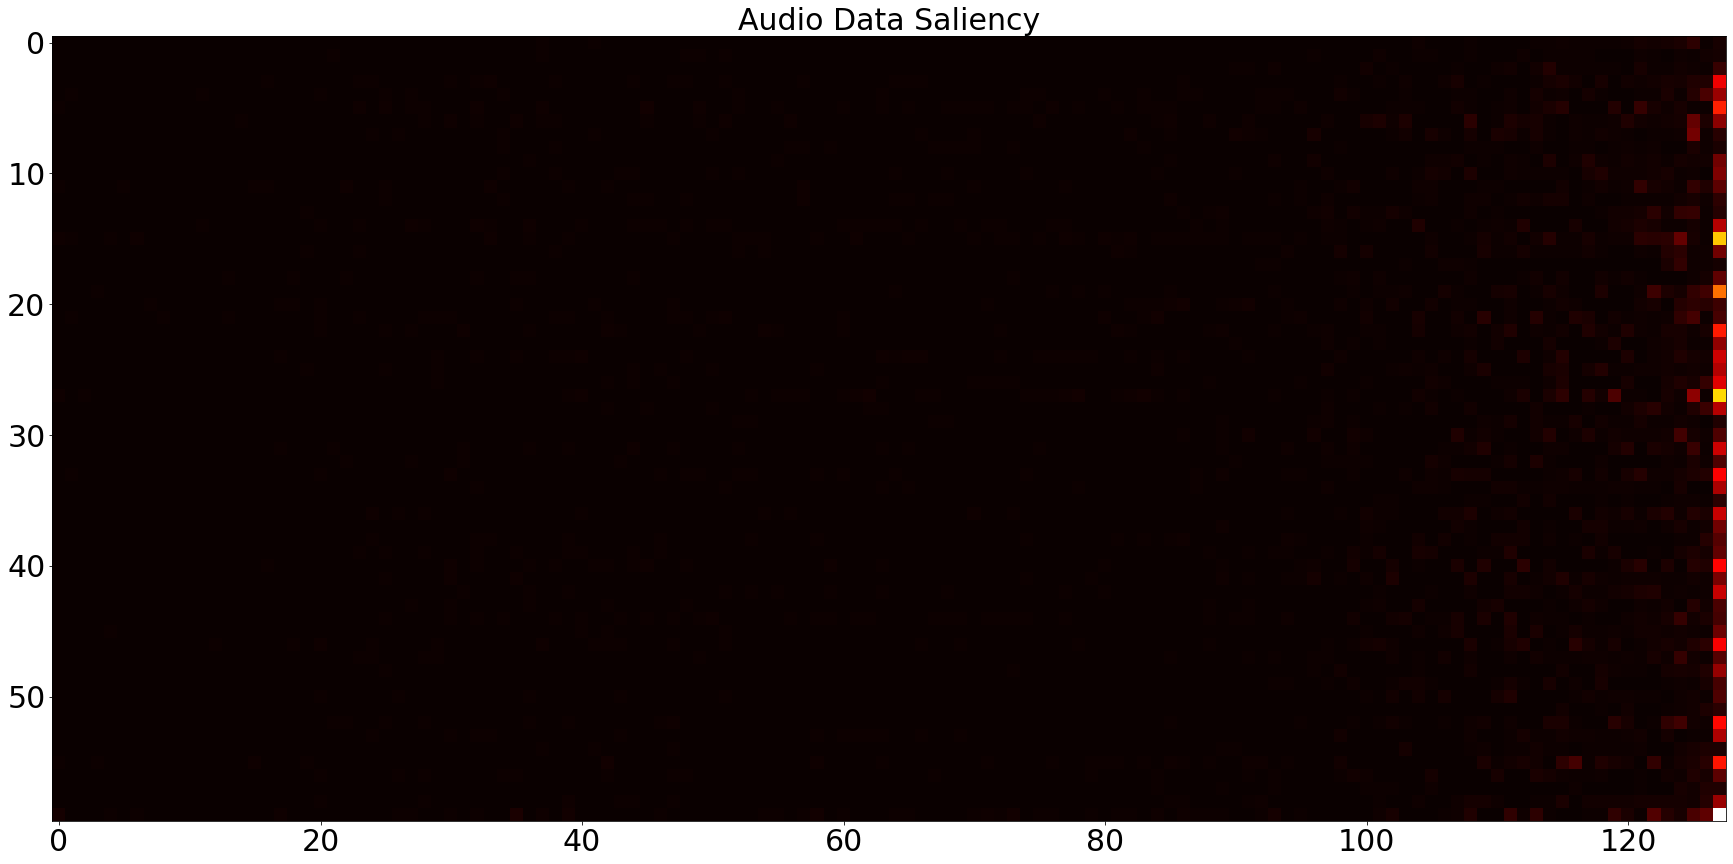

In [97]:
d_saliency = np.empty((0,128))

total_count = 60
for count in range(0,total_count,1):
    X_data, y_data = get_data_from_location('random', 0)
    X_data = X_data.astype(np.float)
    y_data = y_data.astype(np.long)
    X = mulawEncodeInput(X_data)
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(68)]), X.shape)
    scale = np.broadcast_to(np.array([0.9]), X.shape)
    instrument = np.broadcast_to(np.array([1]), X.shape)

    X = np.stack((input_pitch, scale, instrument, X), axis=1)

    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y_data)


    X_var = Variable(X, requires_grad=True).cuda()
    X_var.retain_grad()
    X_var_u = X_var.view(1, 128, 4)
    y_var = Variable(y).cuda()
    saliency = None

    y_pred = model_interp(X_var_u)
    y_pred = activation_toprobs['toprobs'][-1,:]
    y_pred = y_pred[y_var[-1]]
    y_pred.backward()

    saliency = X_var.grad.data
    saliency = saliency.abs() 
    saliency = torch.norm(saliency * X_var, dim=1).reshape(1, -1).detach().cpu().numpy()
    d_saliency = np.append(d_saliency, saliency, axis=0)

plt.plot(X_data)
fig, axes = plt.subplots(nrows=1, figsize=(30, 30))
axes.imshow(d_saliency, cmap=plt.cm.hot)
axes.set_title('Audio Data Saliency', fontdict={'fontsize': 30})
axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

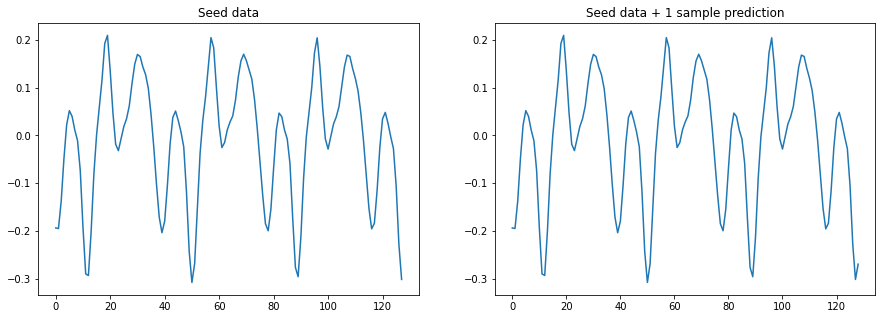

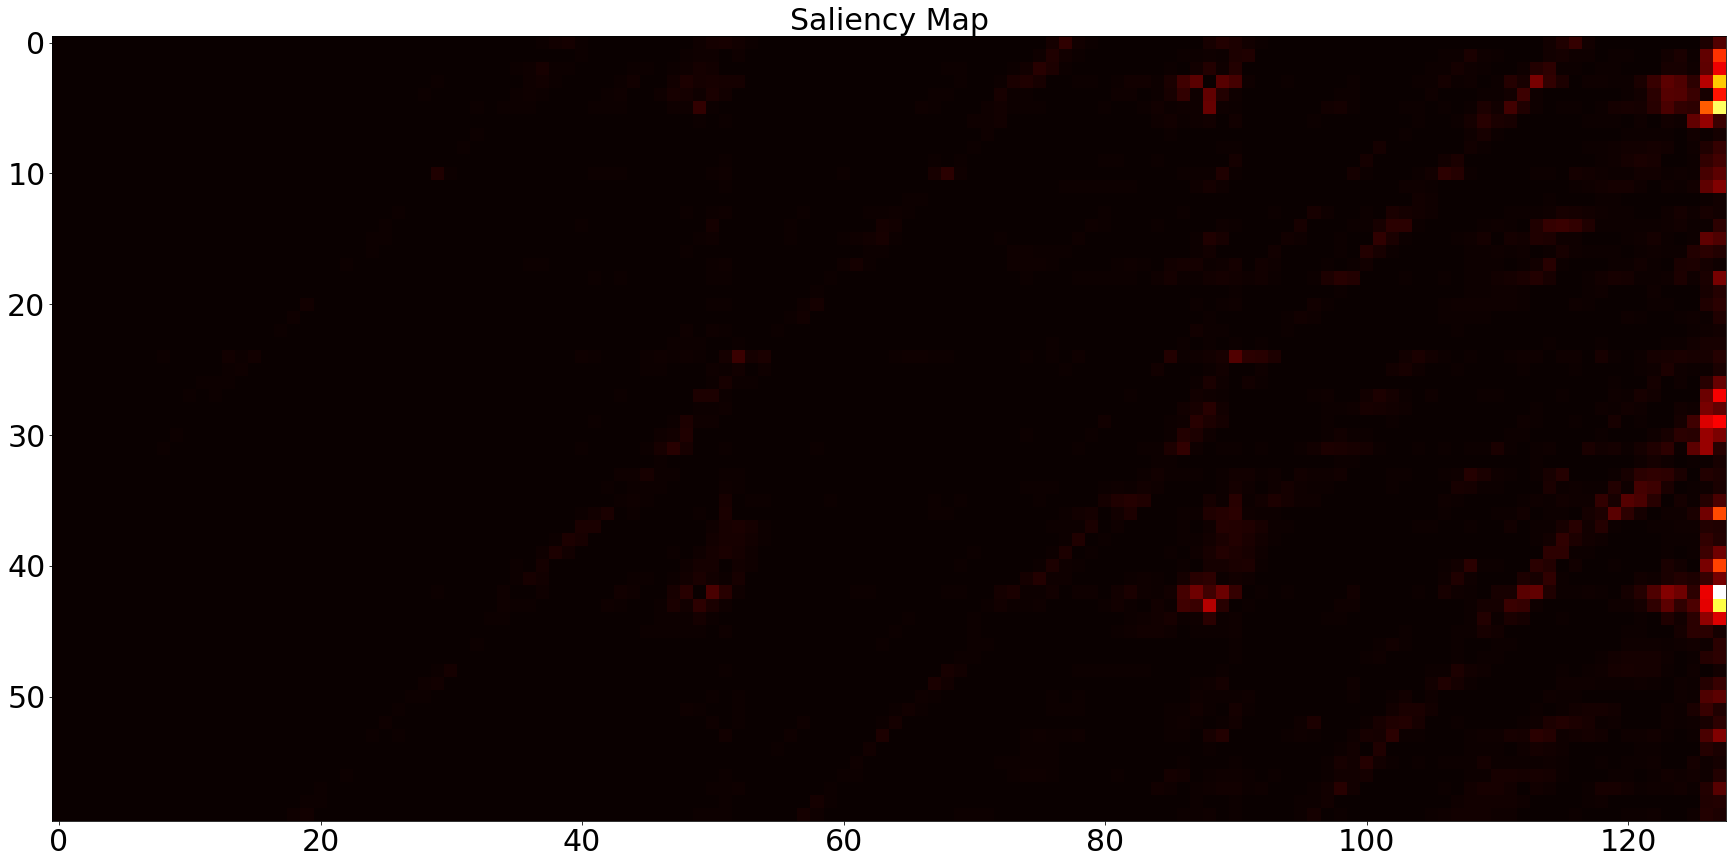

In [96]:
d_saliency = np.empty((0,128))

total_count = 60
for count in range(0,total_count,1):
    X_data, y_data = get_data_from_location('reed_acoustic_000-068-a.90', 993+count)
    X_data = X_data.astype(np.float)
    y_data = y_data.astype(np.long)
    X = mulawEncodeInput(X_data)
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(68)]), X.shape)
    scale = np.broadcast_to(np.array([0.8]), X.shape)
    instrument = np.broadcast_to(np.array([1]), X.shape)

    X = np.stack((input_pitch, scale, instrument, X), axis=1)

    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y_data)


    X_var = Variable(X, requires_grad=True).cuda()
    X_var.retain_grad()
    X_var_u = X_var.view(1, 128, 4)
    y_var = Variable(y).cuda()
    saliency = None

    y_pred = model_interp(X_var_u)
    y_pred_sample = y_pred[0, -1, :].argmax()
    y_pred_sample = mulawDecodeTarget(y_pred_sample.view(1,-1).cpu().numpy())
    X_pred = np.append(X_data, y_pred_sample)
    
    y_pred = activation_toprobs['toprobs'][-1,:]
    y_pred = y_pred[y_var[-1]]
    y_pred.backward()
    
    saliency = X_var.grad.data
    saliency = saliency.abs() 
    saliency = torch.norm(saliency * X_var, dim=1).reshape(1, -1).detach().cpu().numpy()
    d_saliency = np.append(d_saliency, saliency, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Seed data')
axes[0].plot(X_data)

axes[1].set_title('Seed data + 1 sample prediction')
axes[1].plot(X_pred)

fig, axes = plt.subplots(nrows=1, figsize=(30, 30))
axes.imshow(d_saliency, cmap=plt.cm.hot)
axes.set_title('Saliency Map', fontdict={'fontsize': 30})
axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)